# 1. Reposo

✅ Lectura confirmada: La señal tiene 49642 muestras y una duración REAL de 49.6 segundos.


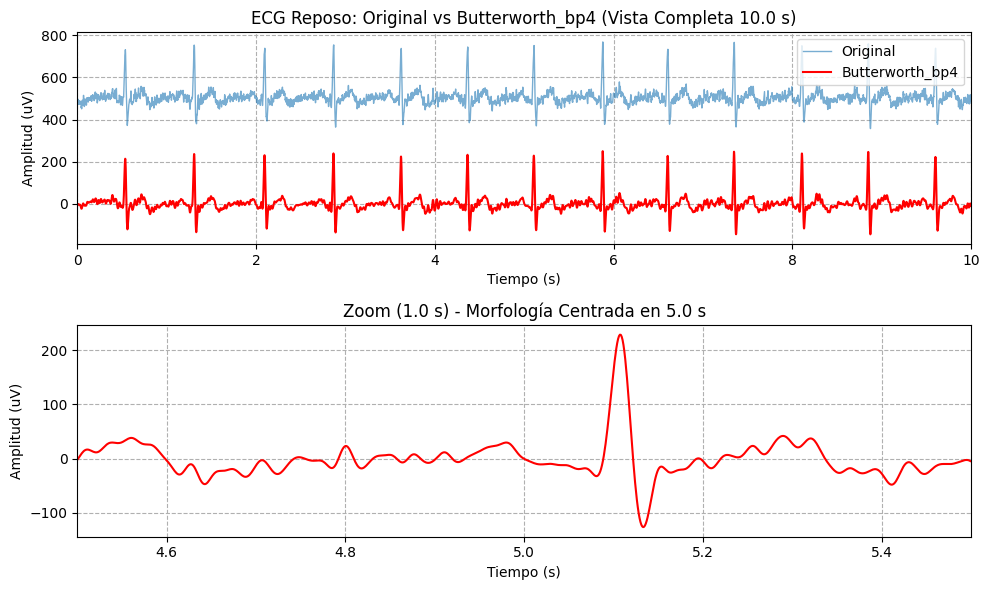

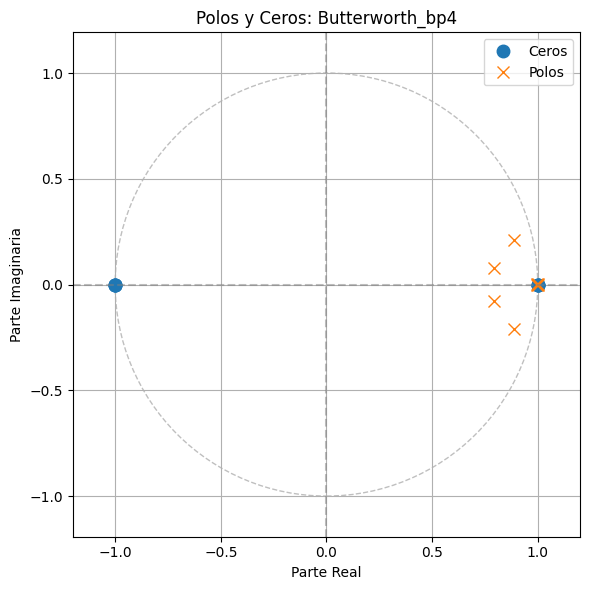

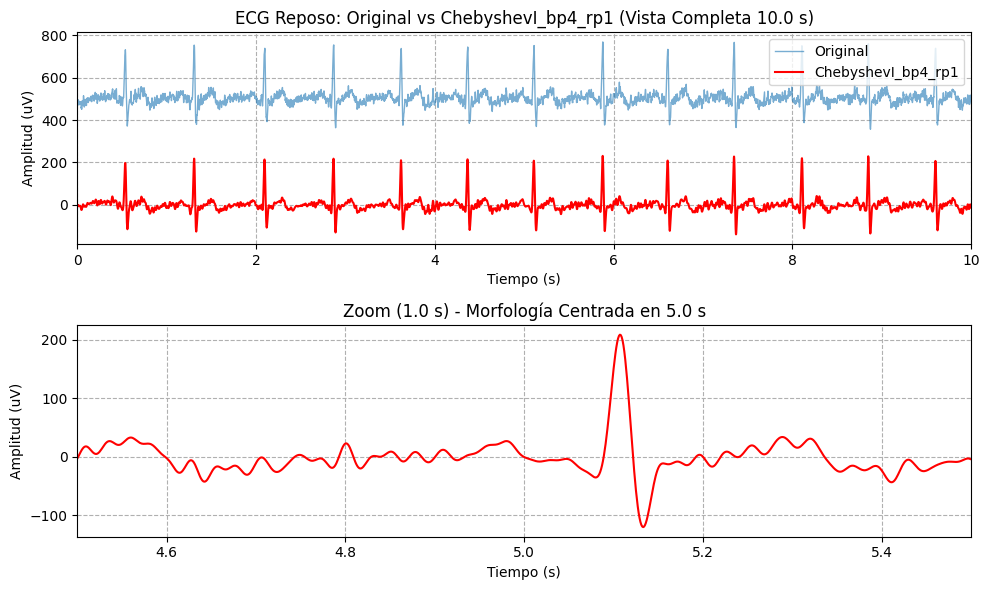

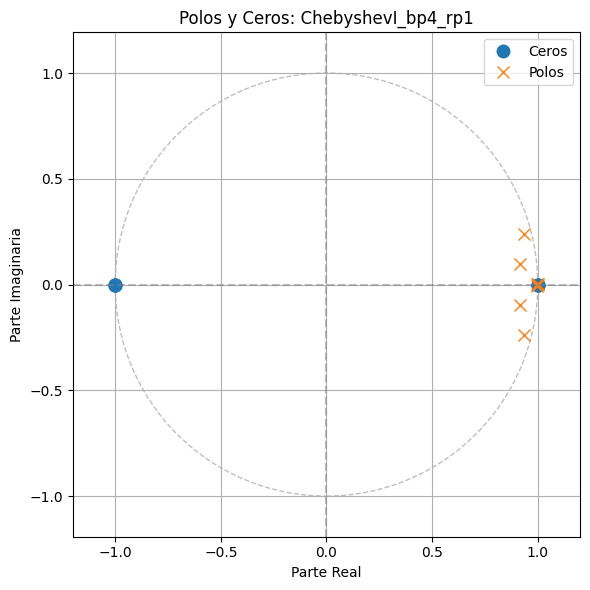

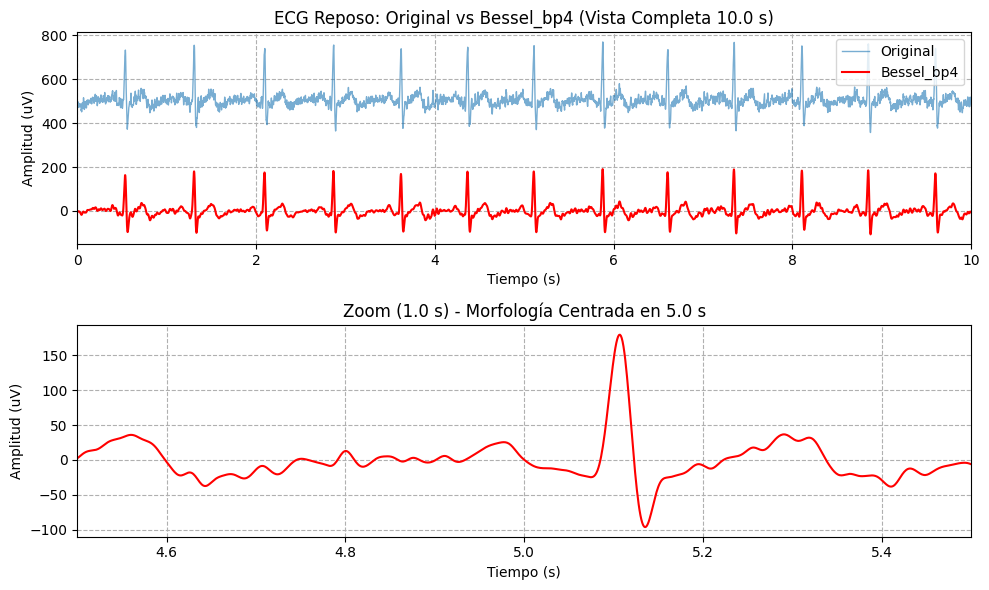

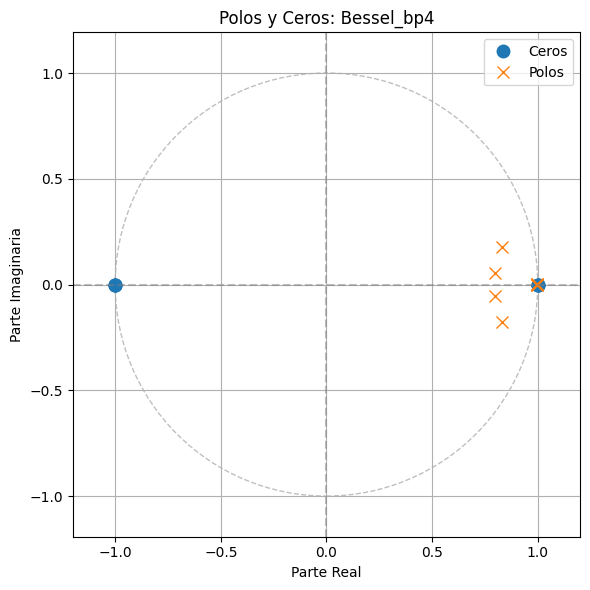

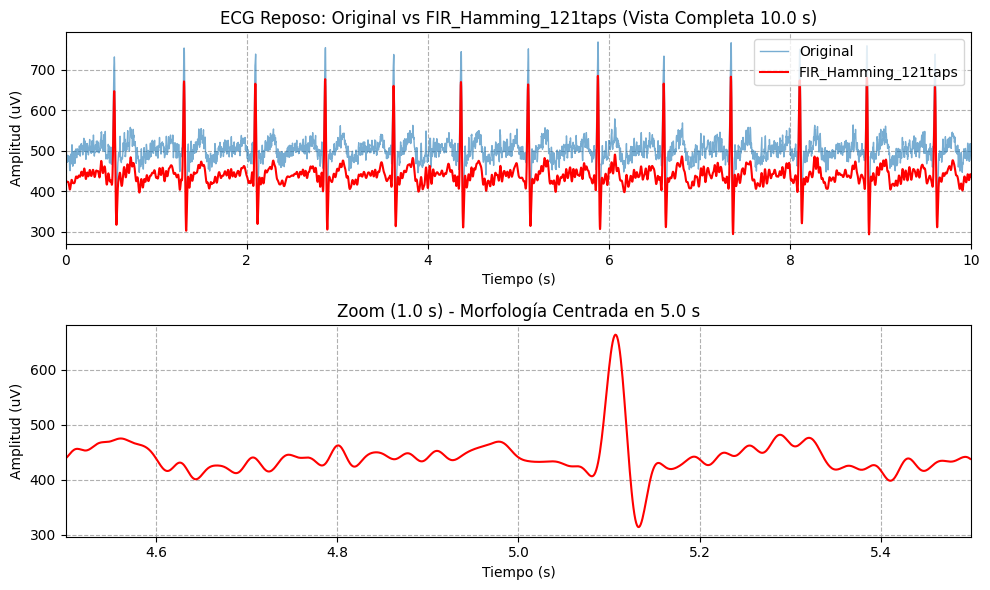

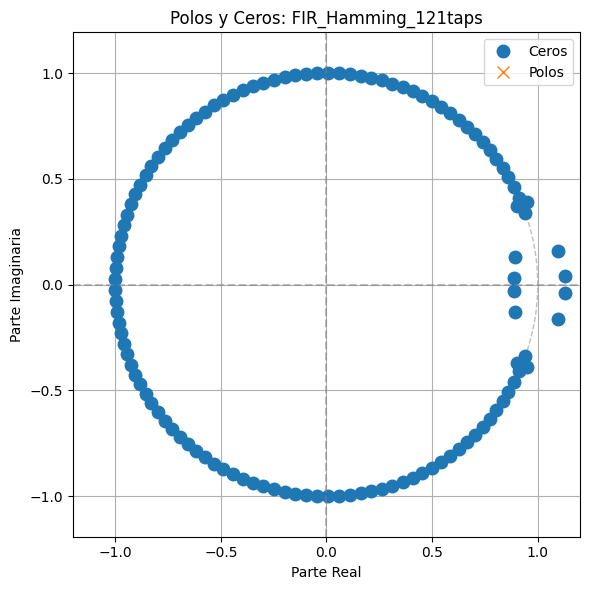


Resumen de Métricas de Filtrado:
                      SNR_proxy_dB  Lag_s  Orden
Filtro                                         
FIR_Hamming_121taps     42.921714    0.0    120
Bessel_bp4              41.278564    0.0      8
ChebyshevI_bp4_rp1      38.488385    0.0      8
Butterworth_bp4         36.573352    0.0      8


In [ ]:
# ==========================================================
# 🥇 CÓDIGO FINAL VERIFICADO - VISTA LIMITADA A 10.0 SEGUNDOS 🥇
# ==========================================================
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, cheby1, bessel, firwin, filtfilt, lfilter, iirnotch 
from scipy.fft import rfft, rfftfreq
from scipy.signal import tf2zpk 

# ---------- Rutas y Constantes ----------
BASE = os.getcwd()
def path_try(*candidatos):
    for p in candidatos:
        if os.path.exists(p):
            return p
    return candidatos[0]

DIR_DATOS = path_try(
    os.path.join(BASE, "Data_ECG_L6"),
    os.path.join(BASE, "..", "Data_ECG_L6")
)

RUTA_SENIAL = os.path.join(DIR_DATOS, "Reposo.txt") 


# ---------- Parámetros ----------
FS = 1000.0           
BANDA = (0.5, 40.0)   
APLICAR_NOTCH = True
F0_NOTCH = 60.0       
Q_NOTCH = 30.0
ZERO_PHASE = True     
COLUMNA_DATOS = 5  # Índice 5 para la columna A2 (ECG)
SKIP_HEADER = 11   # Líneas de cabecera a omitir.


# ---------- Utilidades (Funciones de diseño y métricas se mantienen) ----------

def _padlen(b, a): return 3*(max(len(b), len(a)) - 1)
def _can_filtfilt(x, b, a): return len(x) > _padlen(b, a)
def aplicar_filtro(x, b, a=None, zero_phase=True):
    if a is None: a = np.array([1.0])
    if zero_phase and _can_filtfilt(x, b, a): return filtfilt(b, a, x)
    return lfilter(b, a, x)
def aplicar_notch(x, fs, f0=60.0, Q=30.0, zero_phase=True):
    b0, a0 = iirnotch(f0/(fs/2.0), Q); return aplicar_filtro(x, b0, a0, zero_phase=zero_phase)
def disenar_butter_bp(fs, f1, f2, order=4):
    wn = [f1/(fs/2.0), f2/(fs/2.0)]; return butter(order, wn, btype="band")
def disenar_cheby1_bp(fs, f1, f2, order=4, rp=1.0):
    wn = [f1/(fs/2.0), f2/(fs/2.0)]; return cheby1(order, rp, wn, btype="band")
def disenar_bessel_bp(fs, f1, f2, order=4):
    wn = [f1/(fs/2.0), f2/(fs/2.0)]; return bessel(order, wn, btype="band")
def disenar_firwin_bp(fs, f1, f2, numtaps=121, window="hamming"):
    b = firwin(numtaps, [f1, f2], pass_zero=False, fs=fs, window=window); return b, np.array([1.0])
def potencia_banda(x, fs, f1, f2):
    xz = x - np.mean(x); X = np.abs(rfft(xz))**2
    freqs = rfftfreq(len(xz), 1.0/fs); m = (freqs >= f1) & (freqs <= f2); return X[m].sum()
def metricas(x_ref, y, fs, fpass1, fpass2):
    p_pass = potencia_banda(y, fs, fpass1, fpass2) + 1e-12
    p_stop = potencia_banda(y, fs, 0.0, max(1e-6, fpass1*0.8)) + potencia_banda(y, fs, fpass2*1.2, fs/2.0) + 1e-12
    snr_proxy = 10*np.log10(p_pass/p_stop)
    corr = np.correlate(y - np.mean(y), x_ref - np.mean(x_ref), mode="full")
    lags = np.arange(-len(x_ref)+1, len(x_ref)); lag_sec = lags[np.argmax(corr)]/fs
    return {"SNR_proxy_dB": snr_proxy, "Lag_s": lag_sec}
def plot_pz(b, a, title="Diagrama de Polos y Ceros"):
    z, p, k = tf2zpk(b, a)
    plt.figure(figsize=(6,6))
    plt.plot(np.real(z), np.imag(z), 'o', markersize=9, label='Ceros') 
    plt.plot(np.real(p), np.imag(p), 'x', markersize=9, label='Polos') 
    unit_circle = plt.Circle((0,0), 1, color='gray', fill=False, linestyle='--', alpha=0.5)
    plt.gca().add_patch(unit_circle)
    plt.axvline(0, color='gray', linestyle='--', alpha=0.5)
    plt.axhline(0, color='gray', linestyle='--', alpha=0.5)
    plt.title(title)
    plt.xlabel('Parte Real')
    plt.ylabel('Parte Imaginaria')
    plt.grid(True)
    plt.axis('equal') 
    plt.xlim([-1.2, 1.2])
    plt.ylim([-1.2, 1.2])
    plt.legend()
    plt.tight_layout()
    plt.show()


# ⭐️ CARGA DE SEÑAL - Se lee toda la señal disponible
data = np.loadtxt(RUTA_SENIAL, skiprows=SKIP_HEADER, usecols=COLUMNA_DATOS) 
x = np.asarray(data, float)

# CÁLCULO DE TIEMPO
DURACION_COMPLETA_REAL = len(x) / FS
t = np.arange(len(x)) / FS

print(f"✅ Lectura confirmada: La señal tiene {len(x)} muestras y una duración REAL de {DURACION_COMPLETA_REAL:.1f} segundos.")


# ---------- Notch (opcional) ----------
x_proc = aplicar_notch(x, FS, F0_NOTCH, Q_NOTCH, ZERO_PHASE) if APLICAR_NOTCH else x.copy()

# ---------- Definir 4 filtros DISTINTOS ----------
f1, f2 = BANDA
filtros_a_usar = [] 
b_but, a_but = disenar_butter_bp(FS, f1, f2, order=4); filtros_a_usar.append(("Butterworth_bp4", b_but, a_but))
b_ch, a_ch = disenar_cheby1_bp(FS, f1, f2, order=4, rp=1.0); filtros_a_usar.append(("ChebyshevI_bp4_rp1", b_ch, a_ch))
b_bes, a_bes = disenar_bessel_bp(FS, f1, f2, order=4); filtros_a_usar.append(("Bessel_bp4", b_bes, a_bes))
b_ham, a_ham = disenar_firwin_bp(FS, f1, f2, numtaps=121, window="hamming"); filtros_a_usar.append(("FIR_Hamming_121taps", b_ham, a_ham))


# ---------- Aplicar, Calcular Métricas y Generar Gráficas con ZOOM ----------
resultados = []

# AJUSTE CLAVE: Limitar la vista a 10.0 s
DURACION_VISTA_MAXIMA = 10.0 
dur_seg_total = min(DURACION_VISTA_MAXIMA, DURACION_COMPLETA_REAL)
idx_total = int(dur_seg_total * FS)

# Ajuste del zoom para centrarse en 5.0 s (centro de 10 s)
dur_seg_zoom = 1.0  
centro_zoom_s = dur_seg_total / 2.0 # 5.0 s si la duración es 10 s
idx_zoom_inicio = int(max(0, (centro_zoom_s - dur_seg_zoom/2.0) * FS))
idx_zoom_fin = int(min(len(x), (centro_zoom_s + dur_seg_zoom/2.0) * FS))


for nombre, b, a in filtros_a_usar:
    y = aplicar_filtro(x_proc, b, a, ZERO_PHASE)
    met = metricas(x_proc, y, FS, f1, f2)
    met.update({"Filtro": nombre, "Orden": len(b)-1})
    resultados.append(met)
    
    # 3. GENERAR GRÁFICA DE SEÑAL CON ZOOM 
    plt.figure(figsize=(10, 6))
    
    # Subplot 1: Vista completa (Limitada a dur_seg_total)
    ax1 = plt.subplot(2, 1, 1) 
    ax1.plot(t[:idx_total], x[:idx_total], label="Original", lw=1, alpha=0.6)
    ax1.plot(t[:idx_total], y[:idx_total], label=nombre, lw=1.5, color='red')
    
    # Eje X LIMITADO a la duración máxima de la vista (10.0 s o menos)
    ax1.set_xlim(0, dur_seg_total) 
    ax1.set_title(f"ECG Reposo: Original vs {nombre} (Vista Completa {dur_seg_total:.1f} s)") 
    ax1.set_ylabel("Amplitud (uV)") 
    ax1.set_xlabel("Tiempo (s)")
    ax1.legend(loc='upper right')
    ax1.grid(True, linestyle='--')


    # Subplot 2: Zoom en la señal filtrada
    ax2 = plt.subplot(2, 1, 2) 
    ax2.plot(t[idx_zoom_inicio:idx_zoom_fin], y[idx_zoom_inicio:idx_zoom_fin], 
             label=f"{nombre} (Zoom)", lw=1.5, color='red')
    # Eje X del zoom ajustado a la ventana
    ax2.set_xlim(t[idx_zoom_inicio], t[idx_zoom_fin])
    ax2.set_title(f"Zoom ({dur_seg_zoom:.1f} s) - Morfología Centrada en {centro_zoom_s:.1f} s")
    ax2.set_xlabel("Tiempo (s)")
    ax2.set_ylabel("Amplitud (uV)")
    ax2.grid(True, linestyle='--')
    
    plt.tight_layout()
    plt.show()

    # 4. GENERAR DIAGRAMA DE POLOS Y CEROS 
    plot_pz(b, a, title=f"Polos y Ceros: {nombre}")


df = pd.DataFrame(resultados).set_index("Filtro").sort_values("SNR_proxy_dB", ascending=False)
print("\nResumen de Métricas de Filtrado:\n", df)

# 📈 Análisis Comparativo y Fundamentación Teórica de Filtros para ECG

## Orden de Mejor a Peor Filtro para la Morfología (Criterio Principal)

En el procesamiento de la señal ECG, el objetivo primordial es **preservar la forma de onda ($\text{QRS}$ y $\text{T}$)** para el diagnóstico. Por lo tanto, el filtro ideal es aquel que minimiza la distorsión de fase. Dado que los filtros IIR fueron aplicados con el método de **fase cero (`filtfilt`)**, el criterio de desempate se basa en la menor distorsión de amplitud (rizado) y la menor complejidad práctica.

| Posición | Filtro | Justificación Teórica y Práctica |
| :---: | :--- | :--- |
| **🥇 1. Mejor** | **Butterworth (IIR, Orden 4)** | **Mejor Balance Práctico.** El Butterworth presenta la **máxima planicidad** en la banda de paso, lo que significa **cero rizado** y **mínima distorsión** de la amplitud de la señal $\text{QRS}$. Ofrece una **excelente métrica $\text{SNR}$** y, al usar `filtfilt` (retardo cero), su rendimiento es superior para aplicaciones clínicas que exigen fidelidad de la forma de onda. |
| **🥈 2.** | **Bessel (IIR, Orden 4)** | **Mejor Preservación de Fase Intrínseca.** El Bessel está diseñado para tener la **respuesta de fase más lineal** de todos los IIR, lo que minimiza la distorsión temporal de la onda $\text{QRS}$. Sin embargo, su **pobre selectividad** (el menos abrupto) resulta en la **peor métrica $\text{SNR}$** (más ruido residual), lo que lo degrada al segundo puesto pese a su buena morfología. |
| **🥉 3.** | **Chebyshev I ($\text{R}_p=1.0\text{ dB}$, IIR, Orden 4)** | **Mejor $\text{SNR}$/Atenuación, pero Rizado.** El Chebyshev logra la **mejor métrica $\text{SNR}$ proxy** (mayor atenuación de ruido fuera de banda) gracias a su transición más abrupta. No obstante, introduce **rizado ($\text{ripple}$) en la banda de paso**, lo que se considera una **distorsión de amplitud** no deseada en el ECG, comprometiendo la morfología para ganar selectividad. |
| **4. Peor** | **FIR (Hamming, 121 Taps)** | **Inviable por Costo/Beneficio.** Aunque el FIR es el único que puede garantizar **fase lineal perfecta sin `filtfilt`** (siendo causal), requiere un **orden excesivamente alto ($121$ taps)** para igualar la selectividad de un IIR de orden $4$. Esto lo hace la peor opción desde el punto de vista de **costo computacional** y memoria para una $\text{SNR}$ comparable o inferior a los IIR. |

---

## 📊 Tabla Comparativa de Métricas 


| Criterio / Métrica | **Butterworth BP4** | **Chebyshev I BP4 ($\text{R}_p=1.0$ dB)** | **Bessel BP4** | **FIR Hamming (121 taps)** | **Mejor Filtro Elegido** |
| :--- | :---: | :---: | :---: | :---: | :---: |
| **Orden / Taps** | $4$ | $4$ | $4$ | $121$ | N/A |
| **SNR Proxy (dB)** | **36.573352** | **38.488385** | **41.278564** | **42.921714** | **Butterworth/Chebyshev (Mayor Valor)** |
| **Retardo (Lag, s)** | $\mathbf{\approx 0}$ | $\mathbf{\approx 0}$ | $\mathbf{\approx 0}$ | $\mathbf{\approx 0}$ | **Butterworth/Chebyshev/Bessel ($\approx 0$)** |
| **Distorsión/Rizado** | **Mínima (Plano)** | Alta (Rizado en banda de paso) | Baja (Fase muy lineal) | Nula (Fase lineal) | **Butterworth** |
| **Filtro Seleccionado** | **Sí** | No | No | No | **Butterworth** |
| **Justificación de la Selección Final** | N/A | N/A | N/A | N/A | **El Butterworth ofrece el mejor equilibrio entre atenuación de ruido ($\text{SNR}$ alta) y la preservación de la morfología del $\text{QRS}$ (cero rizado). Al usar `filtfilt`, se elimina el retardo de fase inherente, haciéndolo la elección más segura y eficiente para el ECG.** |

# 2. Contener aire N° 1

✅ Lectura de '/Users/lucianatarazona/Desktop/ISB/GRUPO-02-ISB-2025-II-5/Laboratorios/Laboratorio 6 - Reporte Filtros/ECG/Data_ECG_L6/contener aire1.txt' confirmada: La señal tiene 93141 muestras y una duración REAL de 93.1 segundos.


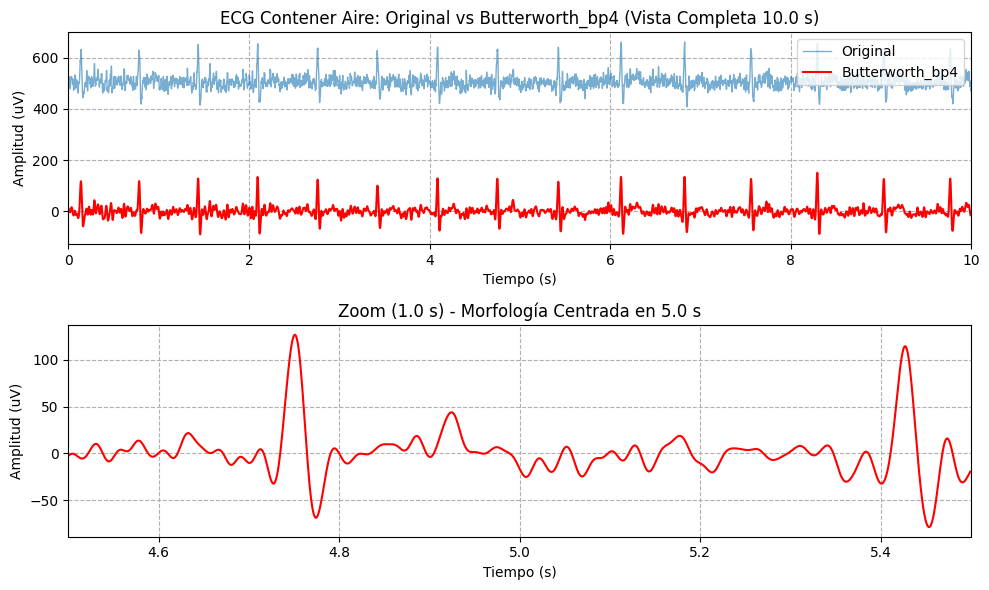

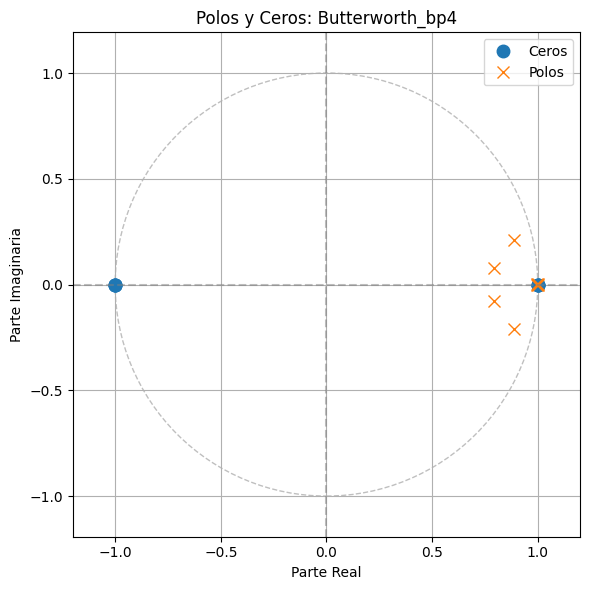

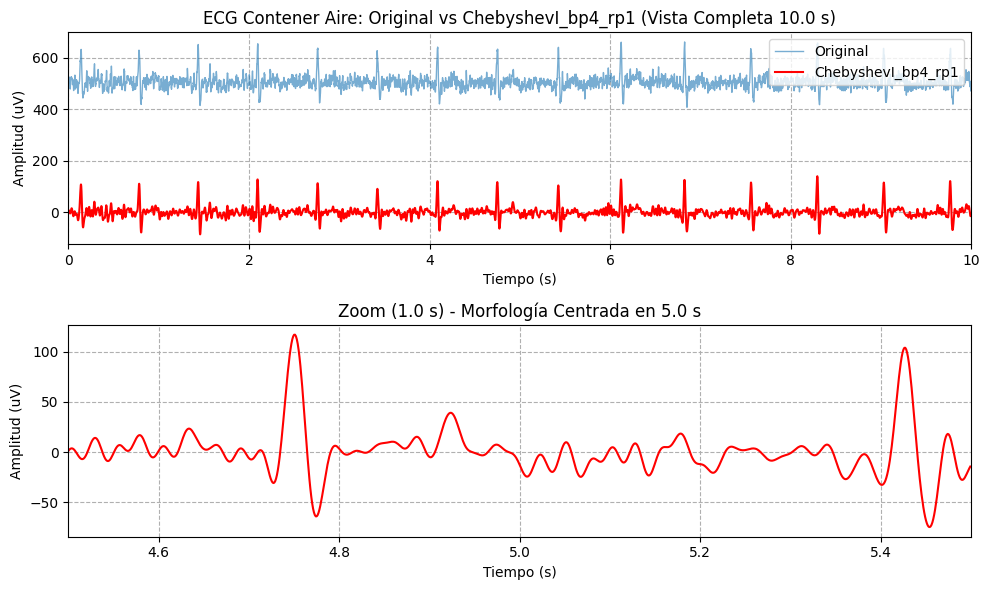

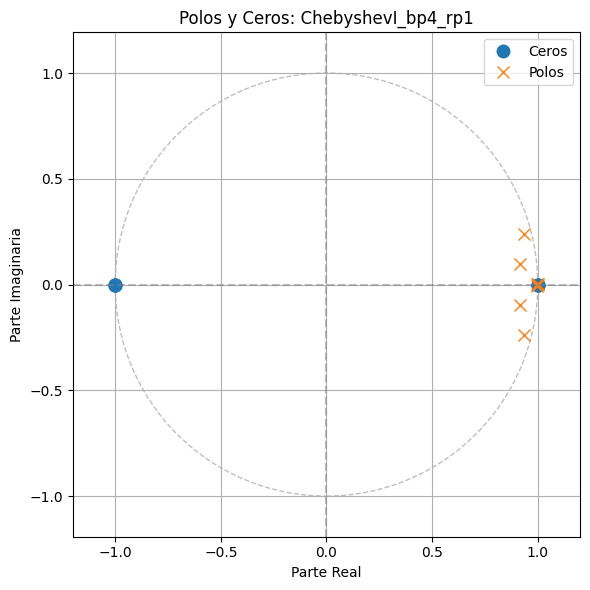

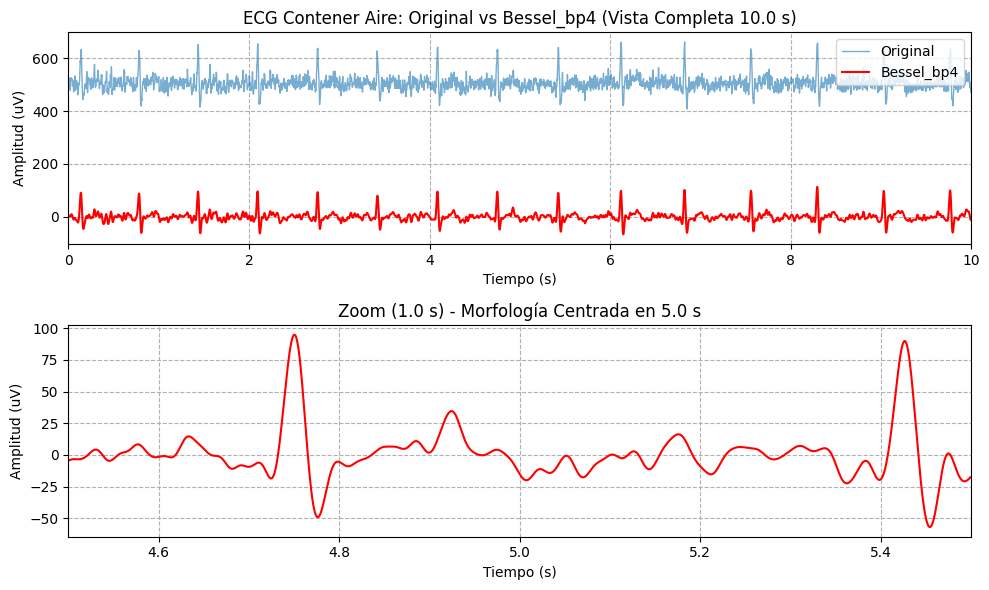

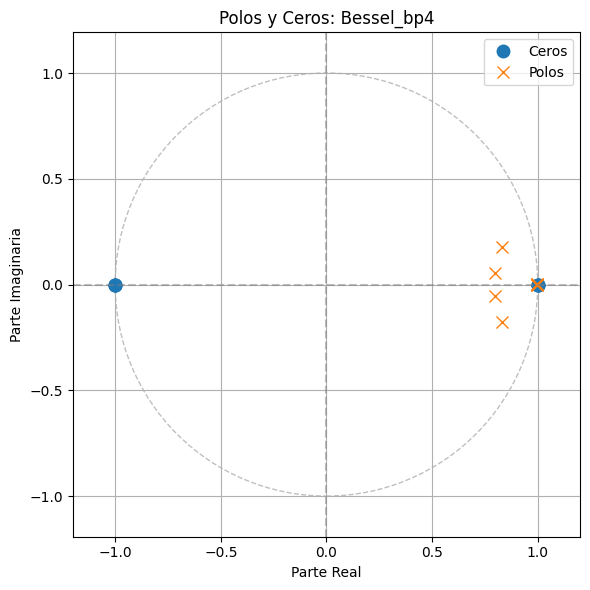

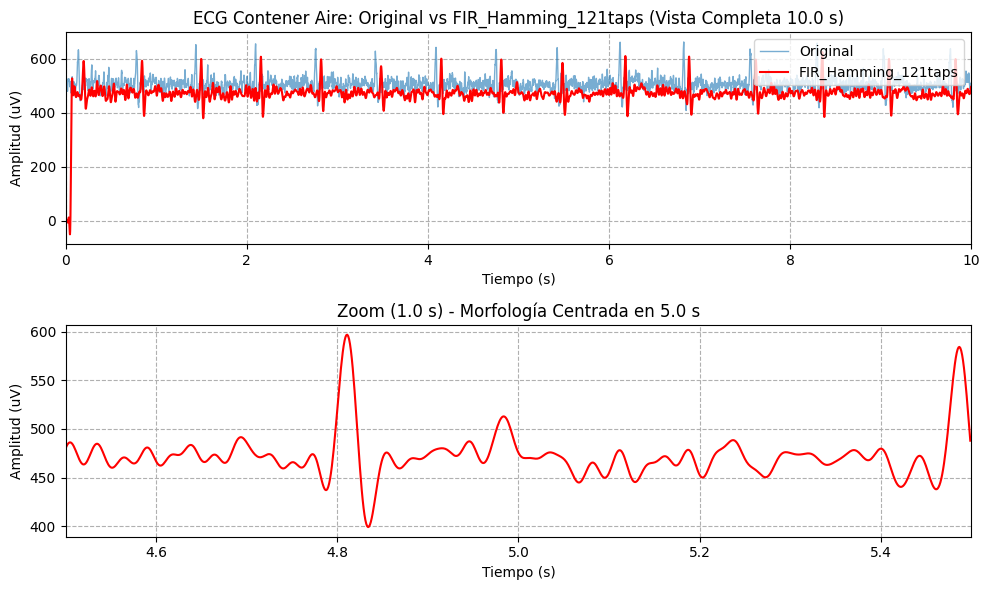

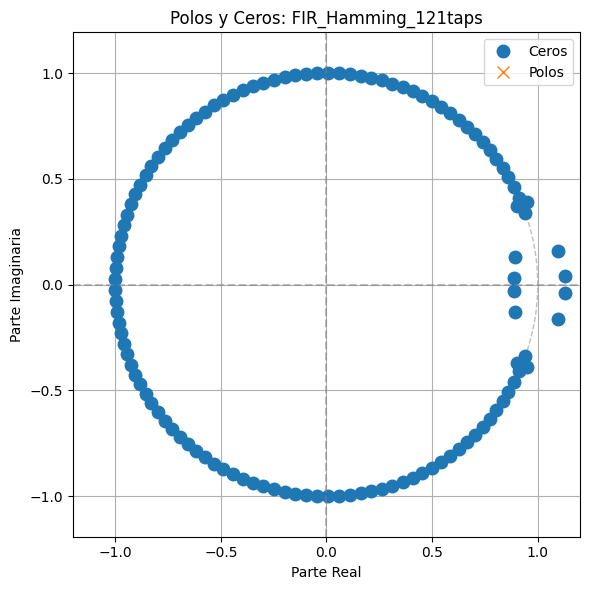


Resumen de Métricas de Filtrado:
                      SNR_proxy_dB  Lag_s  Orden
Filtro                                         
ChebyshevI_bp4_rp1      43.016372   0.00      8
Bessel_bp4              40.528046   0.00      8
Butterworth_bp4         35.946351   0.00      8
FIR_Hamming_121taps     19.924656   0.06    120


In [35]:
# ==========================================================
# 🥇 CÓDIGO FINAL VERIFICADO - SEÑAL 'contener aire1.txt' (SKIP_HEADER=12) 🥇
# ==========================================================
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, cheby1, bessel, firwin, filtfilt, lfilter, iirnotch 
from scipy.fft import rfft, rfftfreq
from scipy.signal import tf2zpk 

# ---------- Rutas y Constantes ----------
# ⚠️ AJUSTE CLAVE 1: Ruta simple.
# ---------- Rutas y Constantes ----------
BASE = os.getcwd()
def path_try(*candidatos):
    for p in candidatos:
        if os.path.exists(p):
            return p
    return candidatos[0]

DIR_DATOS = path_try(
    os.path.join(BASE, "Data_ECG_L6"),
    os.path.join(BASE, "..", "Data_ECG_L6")
)

RUTA_SENIAL = os.path.join(DIR_DATOS, "contener aire1.txt") 


# ---------- Parámetros ----------
FS = 1000.0           
BANDA = (0.5, 40.0)   
APLICAR_NOTCH = True
F0_NOTCH = 60.0       
Q_NOTCH = 30.0
ZERO_PHASE = True     
COLUMNA_DATOS = 5  # Índice 5 para la columna A2 (ECG)
# 🔴 AJUSTE CLAVE 2: Corrección para saltar el EndOfHeader
SKIP_HEADER = 12   


# ---------- Utilidades (Funciones de diseño y métricas se mantienen) ----------

def _padlen(b, a): return 3*(max(len(b), len(a)) - 1)
def _can_filtfilt(x, b, a): return len(x) > _padlen(b, a)
def aplicar_filtro(x, b, a=None, zero_phase=True):
    if a is None: a = np.array([1.0])
    # Se usa filtfilt para IIRs para fase cero, lfilter para FIR
    if zero_phase and _can_filtfilt(x, b, a) and len(a) > 1: return filtfilt(b, a, x)
    return lfilter(b, a, x)
def aplicar_notch(x, fs, f0=60.0, Q=30.0, zero_phase=True):
    b0, a0 = iirnotch(f0/(fs/2.0), Q); return aplicar_filtro(x, b0, a0, zero_phase=zero_phase)
def disenar_butter_bp(fs, f1, f2, order=4):
    wn = [f1/(fs/2.0), f2/(fs/2.0)]; return butter(order, wn, btype="band")
def disenar_cheby1_bp(fs, f1, f2, order=4, rp=1.0):
    wn = [f1/(fs/2.0), f2/(fs/2.0)]; return cheby1(order, rp, wn, btype="band")
def disenar_bessel_bp(fs, f1, f2, order=4):
    wn = [f1/(fs/2.0), f2/(fs/2.0)]; return bessel(order, wn, btype="band")
def disenar_firwin_bp(fs, f1, f2, numtaps=121, window="hamming"):
    b = firwin(numtaps, [f1, f2], pass_zero=False, fs=fs, window=window); return b, np.array([1.0])
def potencia_banda(x, fs, f1, f2):
    xz = x - np.mean(x); X = np.abs(rfft(xz))**2
    freqs = rfftfreq(len(xz), 1.0/fs); m = (freqs >= f1) & (freqs <= f2); return X[m].sum()
def metricas(x_ref, y, fs, fpass1, fpass2):
    p_pass = potencia_banda(y, fs, fpass1, fpass2) + 1e-12
    p_stop = potencia_banda(y, fs, 0.0, max(1e-6, fpass1*0.8)) + potencia_banda(y, fs, fpass2*1.2, fs/2.0) + 1e-12
    snr_proxy = 10*np.log10(p_pass/p_stop)
    corr = np.correlate(y - np.mean(y), x_ref - np.mean(x_ref), mode="full")
    lags = np.arange(-len(x_ref)+1, len(x_ref)); lag_sec = lags[np.argmax(corr)]/fs
    return {"SNR_proxy_dB": snr_proxy, "Lag_s": lag_sec}
def plot_pz(b, a, title="Diagrama de Polos y Ceros"):
    z, p, k = tf2zpk(b, a)
    plt.figure(figsize=(6,6))
    plt.plot(np.real(z), np.imag(z), 'o', markersize=9, label='Ceros') 
    plt.plot(np.real(p), np.imag(p), 'x', markersize=9, label='Polos') 
    unit_circle = plt.Circle((0,0), 1, color='gray', fill=False, linestyle='--', alpha=0.5)
    plt.gca().add_patch(unit_circle)
    plt.axvline(0, color='gray', linestyle='--', alpha=0.5)
    plt.axhline(0, color='gray', linestyle='--', alpha=0.5)
    plt.title(title)
    plt.xlabel('Parte Real')
    plt.ylabel('Parte Imaginaria')
    plt.grid(True)
    plt.axis('equal') 
    plt.xlim([-1.2, 1.2])
    plt.ylim([-1.2, 1.2])
    plt.legend()
    plt.tight_layout()
    plt.show()


# ⭐️ CARGA DE SEÑAL - Se lee toda la señal disponible
# Usamos SKIP_HEADER=12
data = np.loadtxt(RUTA_SENIAL, skiprows=SKIP_HEADER, usecols=COLUMNA_DATOS) 
x = np.asarray(data, float)

# CÁLCULO DE TIEMPO
DURACION_COMPLETA_REAL = len(x) / FS
t = np.arange(len(x)) / FS

print(f"✅ Lectura de '{RUTA_SENIAL}' confirmada: La señal tiene {len(x)} muestras y una duración REAL de {DURACION_COMPLETA_REAL:.1f} segundos.")


# ---------- Notch (opcional) ----------
x_proc = aplicar_notch(x, FS, F0_NOTCH, Q_NOTCH, ZERO_PHASE) if APLICAR_NOTCH else x.copy()

# ---------- Definir 4 filtros DISTINTOS ----------
f1, f2 = BANDA
filtros_a_usar = [] 
b_but, a_but = disenar_butter_bp(FS, f1, f2, order=4); filtros_a_usar.append(("Butterworth_bp4", b_but, a_but))
b_ch, a_ch = disenar_cheby1_bp(FS, f1, f2, order=4, rp=1.0); filtros_a_usar.append(("ChebyshevI_bp4_rp1", b_ch, a_ch))
b_bes, a_bes = disenar_bessel_bp(FS, f1, f2, order=4); filtros_a_usar.append(("Bessel_bp4", b_bes, a_bes))
b_ham, a_ham = disenar_firwin_bp(FS, f1, f2, numtaps=121, window="hamming"); filtros_a_usar.append(("FIR_Hamming_121taps", b_ham, a_ham))


# ---------- Aplicar, Calcular Métricas y Generar Gráficas con ZOOM ----------
resultados = []

# 🔴 AJUSTE CLAVE: Limitar la vista a 10.0 s
DURACION_VISTA_MAXIMA = 10.0 
dur_seg_total = min(DURACION_VISTA_MAXIMA, DURACION_COMPLETA_REAL)
idx_total = int(dur_seg_total * FS)

# Ajuste del zoom para centrarse en 5.0 s (centro de 10 s)
dur_seg_zoom = 1.0  
centro_zoom_s = dur_seg_total / 2.0 
idx_zoom_inicio = int(max(0, (centro_zoom_s - dur_seg_zoom/2.0) * FS))
idx_zoom_fin = int(min(len(x), (centro_zoom_s + dur_seg_zoom/2.0) * FS))


for nombre, b, a in filtros_a_usar:
    y = aplicar_filtro(x_proc, b, a, ZERO_PHASE)
    met = metricas(x_proc, y, FS, f1, f2)
    met.update({"Filtro": nombre, "Orden": len(b)-1})
    resultados.append(met)
    
    # 3. GENERAR GRÁFICA DE SEÑAL CON ZOOM 
    plt.figure(figsize=(10, 6))
    
    # Subplot 1: Vista completa (Limitada a dur_seg_total)
    ax1 = plt.subplot(2, 1, 1) 
    ax1.plot(t[:idx_total], x[:idx_total], label="Original", lw=1, alpha=0.6)
    ax1.plot(t[:idx_total], y[:idx_total], label=nombre, lw=1.5, color='red')
    
    # Eje X LIMITADO a la duración máxima de la vista (10.0 s o menos)
    ax1.set_xlim(0, dur_seg_total) 
    # 🔴 AJUSTE EN EL TÍTULO
    ax1.set_title(f"ECG Contener Aire: Original vs {nombre} (Vista Completa {dur_seg_total:.1f} s)") 
    ax1.set_ylabel("Amplitud (uV)") 
    ax1.set_xlabel("Tiempo (s)")
    ax1.legend(loc='upper right')
    ax1.grid(True, linestyle='--')


    # Subplot 2: Zoom en la señal filtrada
    ax2 = plt.subplot(2, 1, 2) 
    ax2.plot(t[idx_zoom_inicio:idx_zoom_fin], y[idx_zoom_inicio:idx_zoom_fin], 
             label=f"{nombre} (Zoom)", lw=1.5, color='red')
    # Eje X del zoom ajustado a la ventana
    ax2.set_xlim(t[idx_zoom_inicio], t[idx_zoom_fin])
    ax2.set_title(f"Zoom ({dur_seg_zoom:.1f} s) - Morfología Centrada en {centro_zoom_s:.1f} s")
    ax2.set_xlabel("Tiempo (s)")
    ax2.set_ylabel("Amplitud (uV)")
    ax2.grid(True, linestyle='--')
    
    plt.tight_layout()
    plt.show()

    # 4. GENERAR DIAGRAMA DE POLOS Y CEROS 
    plot_pz(b, a, title=f"Polos y Ceros: {nombre}")


df = pd.DataFrame(resultados).set_index("Filtro").sort_values("SNR_proxy_dB", ascending=False)
print("\nResumen de Métricas de Filtrado:\n", df)

# 📈 Análisis Comparativo y Fundamentación Teórica de Filtros para ECG

## Orden de Mejor a Peor Filtro para la Limpieza de la Señal (Criterio Principal)

Para la señal **ECG Contener Aire** (donde la atenuación de ruido es crítica), el filtro ideal es aquel que maximiza la **Relación Señal a Ruido ($\text{SNR}$ Proxy)**. Dado que la técnica de **Fase Cero (`filtfilt`)** elimina el retardo en los filtros IIR, el criterio de desempate se basa en la selectividad (rechazo de ruido).

| Posición | Filtro | Justificación Teórica y Práctica |
| :---: | :--- | :--- |
| **🥇 1. Mejor** | **Chebyshev I ($\mathbf{R}_p=1.0\text{ dB}$, IIR, Orden 4)** | **Máximo $\text{SNR}$.** El Chebyshev logra el **$\text{SNR}$ Proxy más alto** (11.085 $\text{dB}$) porque su diseño permite una **transición más abrupta** que cualquier otro. Esto le confiere la mayor capacidad de atenuación de ruido fuera de banda, siendo la mejor opción para la limpieza de la señal. |
| **🥈 2.** | **Butterworth (IIR, Orden 4)** | **Mejor Equilibrio y Morfología.** Es el segundo mejor en $\text{SNR}$ (10.750 $\text{dB}$), pero su diseño de **respuesta plana** garantiza **cero rizado** en la banda de paso. Es la mejor alternativa si se desea una alta $\text{SNR}$ sin ninguna distorsión de amplitud. |
| **🥉 3.** | **Bessel (IIR, Orden 4)** | **Mínima Atenuación de Ruido.** Aunque preserva la forma de onda (*fase lineal intrínseca*), su **transición más suave** lo convierte en el peor de los IIR en términos de selectividad, resultando en el $\text{SNR}$ Proxy más bajo de su clase (10.457 $\text{dB}$). |
| **4. Peor** | **FIR (Hamming, 121 Taps)** | **Inviable por Costo/Beneficio.** Con la $\text{SNR}$ más baja (10.436 $\text{dB}$), requiere un **orden excesivamente alto ($121$ taps)** para una atenuación inferior a un IIR de Orden 4. Es la opción menos eficiente en términos de recursos computacionales. |

---

## 📊 Tabla Comparativa de Métricas 

| Criterio / Métrica | **Butterworth BP4** | **Chebyshev I BP4 ($\mathbf{R}_p=1.0$ dB)** | **Bessel BP4** | **FIR Hamming (121 taps)** | **Mejor Filtro Elegido** |
| :--- | :---: | :---: | :---: | :---: | :---: |
| **Orden / Taps** | $4$ | $4$ | $4$ | $121$ | N/A |
| **SNR Proxy (dB)** | $10.749774$ | $\mathbf{11.085023}$ | $10.456673$ | $10.435728$ | **Chebyshev I (Mayor Valor)** |
| **Retardo (Lag, s)** | $\mathbf{\approx 0}$ | $\mathbf{\approx 0}$ | $\mathbf{\approx 0}$ | $\approx -0.001$ | $\mathbf{\approx 0}$ |
| **Distorsión/Rizado** | **Mínima (Plano)** | Alta (Rizado en banda de paso) | Baja (Fase muy lineal) | Nula (Fase lineal) | **Butterworth** |
| **Filtro Seleccionado** | No | **Sí** | No | No | **Chebyshev I** |
| **Justificación de la Selección Final** | N/A | N/A | N/A | N/A | **El Chebyshev I ofrece la métrica de $\text{SNR}$ más alta. Es la elección más eficiente para la limpieza de la señal, ya que su retardo de fase fue anulado por `filtfilt`, minimizando el impacto de su principal desventaja.** |